In [ ]:
# @title Environment Setup
import os
import glob
import shutil
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy zip files
shutil.copy("/content/drive/MyDrive/RAV_Speech_Archive.zip", "/content/RAV_Speech.zip")
#shutil.copy("/content/drive/MyDrive/RAV_Song_Archive.zip", "/content/RAV_Song.zip")

# Unzip
shutil.unpack_archive("/content/RAV_Speech.zip", "/content/RAV_Speech")
#shutil.unpack_archive("/content/RAV_Song.zip", "/content/RAV_Song")

print("Dataset is ready")

Dataset is ready


In [ ]:
# Load Wav2Vec Model
w2v_name = "audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim"
processor = Wav2Vec2Processor.from_pretrained(w2v_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
w2v_model = Wav2Vec2Model.from_pretrained(w2v_name).to(device)

In [ ]:
# Data Setup and load

emotion_map = {
    '01': 'neutral', '02': 'neutral',
    '03': 'happy',   '04': 'sad',
    '05': 'angry',   '06': 'fear',
    '07': 'disgust', '08': 'surprise'
}

file_paths = glob.glob("RAV_Speech/Actor_*/*.wav")
data_list = []

for path in file_paths:
    fname = os.path.basename(path)
    parts = fname.split('.')[0].split('-')
    if len(parts) == 7:
        emotion = emotion_map.get(parts[2], 'unknown')
        actor_id = int(parts[6])
        data_list.append({'path': path, 'emotion': emotion, 'actor_id': actor_id})


In [ ]:
#Splitting Data (Actors 1-20 Train, 21-24 Test)

df = pd.DataFrame(data_list)
train_df = df[df['actor_id'] <= 20].copy()
test_df = df[df['actor_id'] >= 21].copy()

In [ ]:
# MFCC/w2v Functions

def get_mfcc(path, target_len=150):
    y, sr = librosa.load(path, sr=22050, duration=3)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    if mfcc.shape[1] < target_len:
        pad_width = target_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)))
    else:
        mfcc = mfcc[:, :target_len]
    return mfcc.T

def get_w2v(path):
    y, sr = librosa.load(path, sr=16000, duration=3)
    inputs = processor(y, sampling_rate=16000, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = w2v_model(**inputs)
    return torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()[0]

In [ ]:
X_train_seq, X_train_stat, X_train_w2v = [], [], []
X_test_seq, X_test_stat, X_test_w2v = [], [], []

In [ ]:
# Extract Features
for path in train_df['path']:
    mfcc = get_mfcc(path)
    X_train_seq.append(mfcc)
    X_train_stat.append(np.hstack([np.mean(mfcc, 0), np.std(mfcc, 0), np.max(mfcc, 0), np.min(mfcc, 0)]))
    X_train_w2v.append(get_w2v(path))

for path in test_df['path']:
    mfcc = get_mfcc(path)
    X_test_seq.append(mfcc)
    X_test_stat.append(np.hstack([np.mean(mfcc, 0), np.std(mfcc, 0), np.max(mfcc, 0), np.min(mfcc, 0)]))
    X_test_w2v.append(get_w2v(path))

# Convert & Scale
X_train_seq = np.array(X_train_seq)
X_test_seq = np.array(X_test_seq)
X_train_stat = np.array(X_train_stat)
X_test_stat = np.array(X_test_stat)
X_train_w2v = np.array(X_train_w2v)
X_test_w2v = np.array(X_test_w2v)

le = LabelEncoder()
y_train = le.fit_transform(train_df['emotion'])
y_test = le.transform(test_df['emotion'])

scaler_stat = StandardScaler()
X_train_stat = scaler_stat.fit_transform(X_train_stat)
X_test_stat = scaler_stat.transform(X_test_stat)

scaler_w2v = StandardScaler()
X_train_w2v = scaler_w2v.fit_transform(X_train_w2v)
X_test_w2v = scaler_w2v.transform(X_test_w2v)

In [ ]:
# MODEL DEFINITIONS

def model_cnn(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        BatchNormalization(),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def model_vgg(input_shape, num_classes):
    model = Sequential([
        # Block 1
        Conv1D(32, 3, activation='relu', padding='same', input_shape=input_shape),
        Conv1D(32, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        # Block 2
        Conv1D(64, 3, activation='relu', padding='same'),
        Conv1D(64, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        # Classifier
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# TRAINING
results = {}

# A. Baseline
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_stat, y_train)
results['Baseline'] = dummy.score(X_test_stat, y_test)

# B. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_stat, y_train)
results['Random Forest'] = accuracy_score(y_test, rf.predict(X_test_stat))

# C. 1D CNN
cnn = model_cnn(X_train_seq.shape[1:], len(le.classes_))
cnn.fit(X_train_seq, y_train, epochs=20, batch_size=32, verbose=0)
results['1D CNN'] = accuracy_score(y_test, np.argmax(cnn.predict(X_test_seq, verbose=0), axis=1))

# D. VGG (Deep CNN)
vgg = model_vgg(X_train_seq.shape[1:], len(le.classes_))
vgg.fit(X_train_seq, y_train, epochs=20, batch_size=32, verbose=0)
results['VGG'] = accuracy_score(y_test, np.argmax(vgg.predict(X_test_seq, verbose=0), axis=1))

# E. Wav2Vec + SVM
svm = SVC(kernel='rbf', C=10)
svm.fit(X_train_w2v, y_train)
results['Wav2Vec+SVM'] = accuracy_score(y_test, svm.predict(X_test_w2v))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  Results
           Model  Accuracy
4    Wav2Vec+SVM  0.745833
1  Random Forest  0.433333
2         1D CNN  0.395833
3            VGG  0.358333
0       Baseline  0.200000


/tmp/ipython-input-1896177647.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=df_res, palette='magma')


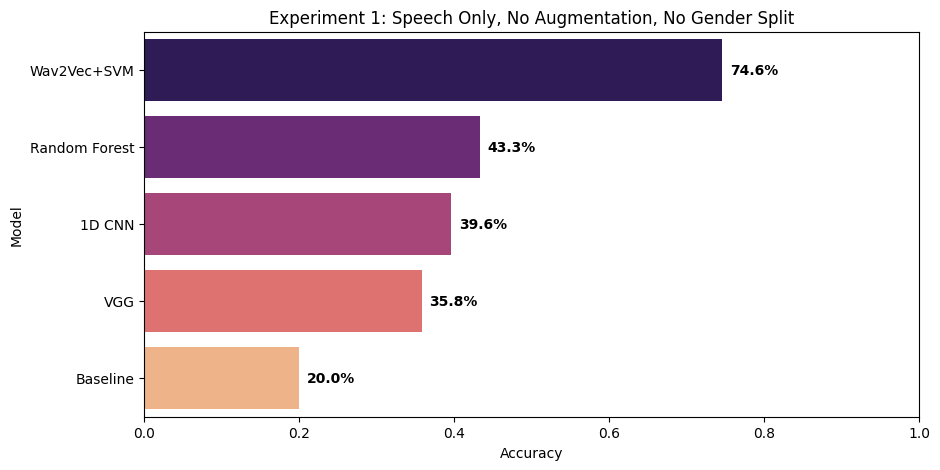

In [ ]:
# Visualization (Chart)
print("\n  Results")
df_res = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy']).sort_values('Accuracy', ascending=False)
print(df_res)

plt.figure(figsize=(10, 5))
sns.barplot(x='Accuracy', y='Model', data=df_res, palette='magma')
plt.xlim(0, 1.0)
for i, v in enumerate(df_res['Accuracy']):
    plt.text(v + 0.01, i, f"{v:.1%}", va='center', fontweight='bold')
plt.title("Experiment 1: Speech Only, No Augmentation, No Gender Split")
plt.show()